In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.algorithms import DART
from src.projections import *
from src.phantom_creator import *

# Instanciate DART
dart = DART()

gray values: [  0. 255.]


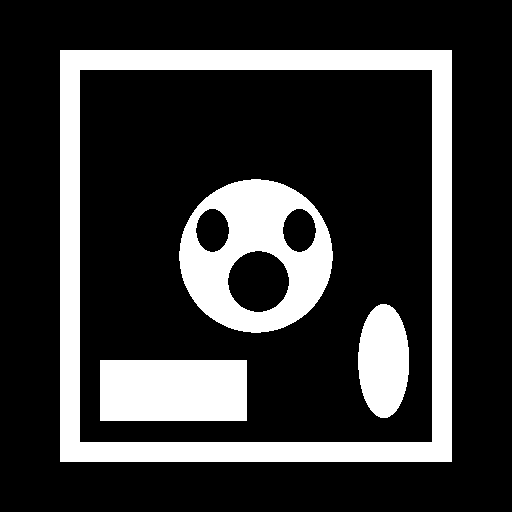

In [5]:
img = np.array(Image.open("phantoms/paws/paw_0.png"), dtype=np.uint8)
img_width, img_height = img.shape

gray_lvls = np.unique(img).astype(np.float16)
print("gray values:",gray_lvls)
Image.fromarray(img)

In [6]:
n_projections = 5
n_detectors = 512
det_spacing = 1
ang_mul = 1
noise_factor = None
angles = np.linspace(0, ang_mul*np.pi, n_projections)

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape

gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
projector_id, sino_id, sinogram = project_from_2D(phantom_id,
                                                vol_geom,
                                                n_projections,
                                                n_detectors,
                                                ang_mul,
                                                angles,
                                                det_spacing,
                                                noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                            n_detectors, angles)

DART mean error 36.31462


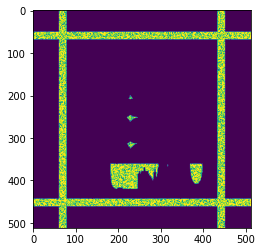

In [8]:
# run the algorithm
dart = DART()
dart_res = dart.test(iters=1,
            gray_levels=gray_lvls,p=0.85,
            vol_shape=img.shape, proj_geom=proj_geom,
            projector_id=projector_id, sino_id=sino_id,
            sinogram=sinogram,
            rec_alg="SART_CUDA", rec_iter=3)

print("DART mean error",np.abs(img - dart_res).mean())
Image.fromarray(dart_res.astype(np.uint8))
plt.imshow(dart_res)

SART mean error 1.654815673828125


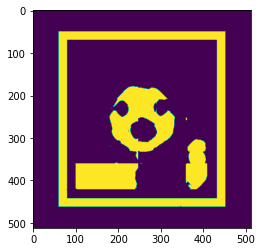

In [16]:
sart_res_id, sart_res = DART().SART(vol_geom, 0, projector_id, sino_id, 20000, use_gpu=True)
#sart_res = dart.segment(sart_res,np.unique(img).astype(np.float16))
print("SART mean error",np.abs(img - sart_res).mean())
plt.imshow(sart_res)

In [1]:
from src.algs import *
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from src.projections import *
from src.phantom_creator import *

# Main parameters
n_projections = 5
n_detectors = 512
det_spacing = 1
noise_factor = None
dart_iters = 300
p = 0.85
rec_alg = 'SART_CUDA'
rec_iters = 200

# open phantom
img = np.array(Image.open("phantoms/paws/paw_0.png"), dtype=np.uint8)
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img = np.array(Image.fromarray(img), dtype=np.uint8)
img_width, img_height = img.shape

vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
# make measurements
angles = np.linspace(0, np.pi, n_projections)
projector_id, sino_id, sinogram = project_from_2D(phantom_id,
                                                vol_geom,
                                                n_projections,
                                                n_detectors,
                                                det_spacing,
                                                angles,
                                                noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)
# instanciate DART
d = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
    proj_geom=proj_geom, projector_id=projector_id,
    sinogram=sinogram)
# run the algorithm
start_ = time.time()
dart_res = d.run(dart_iters,rec_alg,rec_iters)
end_ = time.time()

# run SART for comparison
_, sart_res = SART(vol_geom, 0, projector_id, 
                sino_id, 2000, True)

# print results
print("DART abs mean pixel error:",np.abs(img - dart_res).mean())
print("Run time:", np.round(end_ - start_,2))
print("SART abs mean pixel error:", np.abs(img - sart_res).mean())

TypeError: 'int' object is not subscriptable

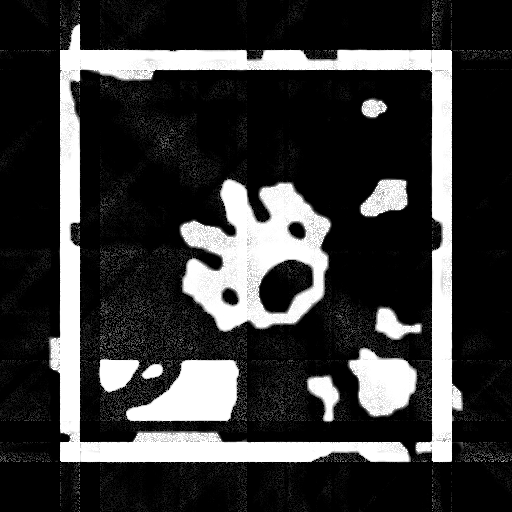

In [ ]:
Image.fromarray(dart_res.astype(np.uint8))

In [8]:
np.unique(dart_res)

array([0], dtype=uint8)